In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/vae/lfw (1).zip'

In [ ]:
path = '/content/lfw'
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

#`PyTorch DataLoader and Transformation Setup`

---

1. `Defining Transformations`:
The line transform = transforms.Compose([transforms.ToTensor()]) initializes a transformation pipeline. transforms.Compose is used to chain together multiple image transformations. In this case, there is only one transformation - transforms.ToTensor(), which converts PIL images or NumPy arrays into PyTorch tensors, normalizing the pixel values to the range [0.0, 1.0].

2. `Initializing the DataLoader`:
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True) creates a DataLoader object for iterating over the dataset.

 1. `ImageFolder Dataset`: ImageFolder(path, transform,) loads images from the specified path, where each subdirectory contains images of a specific class. The transform is applied to each image.

  2. `Batch Size`: batch_size=32 configures the DataLoader to provide batches of 32 images at a time. This is crucial for batch processing in model training.

   3. `Shuffling`: shuffle=True indicates that the dataset should be shuffled at the beginning of each epoch, promoting model generalization by reducing order bias.

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

MPS device not found.
Using GPU: Tesla T4


Image Shape: torch.Size([250, 250, 3])


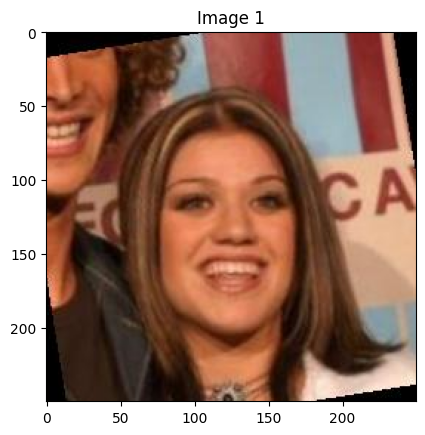

In [ ]:
import matplotlib.pyplot as plt

# Initialize a counter to keep track of the number of images displayed
num_images_to_display = 1
image_counter = 0

# Iterate through the dataloader
for x, y in dataloader:
    # Iterate through the batch
    for i in range(len(x)):
        # Get an individual image and its shape
        image = x[i].permute(1, 2, 0)
        image_shape = image.shape

        # Print the shape of the image
        print(f"Image Shape: {image_shape}")

        # Display the image
        plt.figure()
        plt.imshow(image)
        plt.title(f"Image {image_counter + 1}")
        plt.show()

        # Increment the image counter
        image_counter += 1

        # Check if the desired number of images has been displayed
        if image_counter >= num_images_to_display:
            break

    # Check if the desired number of images has been displayed
    if image_counter >= num_images_to_display:
        break


# Visualizing Images from DataLoader

---

1. **Iterating Over the DataLoader:**
   - This code begins by iterating through the batches in the DataLoader. Each batch contains a set of images and their corresponding labels (or targets).

2. **Selecting the First Image:**
   - The code `x[0]` selects the first image in the batch. In PyTorch, images in a batch are typically stacked along the first dimension.

3. **Permuting Dimensions:**
   - The `.permute(1, 2, 0)` method changes the order of the dimensions of the image from (C, H, W) (Channels, Height, Width) to (H, W, C) (Height, Width, Channels). This is the format expected by matplotlib for RGB images.

4. **Converting to Numpy Array:**
   - Matplotlib expects a numpy array for image visualization. The tensor is converted to a numpy array using `.numpy()`.

5. **Rescaling:**
   - If the image tensor is normalized (values between 0 and 1), it's rescaled to a range of 0 to 255 and converted to uint8 for proper visualization. This step is necessary for displaying the image correctly.

6. **Displaying the Image:**
   - `plt.imshow(image_to_show)` is used to display the image. Here, `image_to_show` is the image after performing the above steps.

7. **Breaking After the First Batch:**
   - The `break` statement ensures that the loop exits after processing the first batch, hence displaying only the first image of the first batch.

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

# In-Depth Difference between Autoencoders (AEs) and Variational Autoencoders (VAEs)

---

1. **Difference in Applications:**

   - *Autoencoders (AEs):*
     - **Applications:** AEs are versatile and often used for various tasks, including data compression, denoising, feature learning, and dimensionality reduction. They excel in reconstructing input data and extracting meaningful representations.
     - **Use Cases:** AEs are suitable for tasks such as image denoising, reducing the dimensionality of high-dimensional data, and extracting features for downstream tasks like classification.

   - *Variational Autoencoders (VAEs):*
     - **Applications:** VAEs extend the capabilities of AEs by introducing probabilistic modeling, making them highly valuable for generative tasks. They are commonly used for generating new data samples, interpolating between data points, and data augmentation.
     - **Use Cases:** VAEs are well-suited for generating images with variations (e.g., generating diverse faces), generating text sequences (e.g., generating diverse sentences), and performing data augmentation by generating new data samples.

2. **Difference in Architecture:**

   - *Autoencoders (AEs):*
     - **Architecture:** AEs consist of an encoder and a decoder. The encoder maps the input data to a fixed latent space representation, while the decoder reconstructs the input from this representation.
     - **Encoding:** AEs use deterministic encoders, which means that for the same input, they produce the same fixed latent representation every time.

   - *Variational Autoencoders (VAEs):*
     - **Architecture:** VAEs also include an encoder and a decoder, similar to AEs. However, VAEs introduce probabilistic modeling in the encoder, resulting in a stochastic latent space.
     - **Encoding:** VAEs use probabilistic encoders that produce not just a single fixed latent representation but a probability distribution over the latent space. This enables capturing uncertainty in the encoding process and allows for the generation of diverse samples from the same input.

3. **Difference in Sampling from Latent Space:**

   - *Autoencoders (AEs):*
     - **Sampling:** AEs do not explicitly sample from the latent space. The latent space is a fixed, deterministic representation of the input data.

   - *Variational Autoencoders (VAEs):*
     - **Sampling:** VAEs explicitly sample from the latent space during both encoding and generation. The stochasticity of the latent space allows VAEs to generate diverse data samples from the same input.

4. **Difference in Regularization:**

   - *Autoencoders (AEs):*
     - **Regularization:** AEs rely on regularization techniques such as dropout or weight decay to prevent overfitting. Regularization in AEs is typically applied to the neural network layers.

   - *Variational Autoencoders (VAEs):*
     - **Regularization:** VAEs have built-in regularization through the KL-divergence loss term. This term encourages the latent space to follow a predefined prior distribution (e.g., Gaussian) and ensures that the latent space is smooth and continuous.

5. **Difference in Training Objective:**

   - *Autoencoders (AEs):*
     - **Training Objective:** The primary objective in AEs is to minimize the reconstruction loss. The model aims to faithfully reconstruct the input data.

   - *Variational Autoencoders (VAEs):*
     - **Training Objective:** VAEs optimize a combination of the reconstruction loss and the KL-divergence loss. While the reconstruction loss ensures reconstruction quality, the KL-divergence loss shapes the latent space.

---

In summary, AEs and VAEs differ significantly in their applications, architecture, and training objectives. While AEs are versatile and deterministic, primarily used for tasks like feature learning and data reconstruction, VAEs excel in generative tasks due to their probabilistic modeling of the latent space, enabling the generation of diverse and structured data samples. VAEs also incorporate explicit sampling from the latent space and regularization through the KL-divergence loss. These differences make VAEs a powerful tool for generative modeling and representation learning.


# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [ ]:
import torch.nn.functional as F

class VAE(nn.Module):

    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(128 * 32 * 32, latent_dim)
        self.fc_log_var = nn.Linear(128 * 32 * 32, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128 * 32 * 32)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # Sigmoid for output in [0, 1]
        )

    def encoder(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, x):
        x = self.decoder_fc(x)
        x = x.view(x.size(0), 128, 32, 32)
        return self.decoder_conv(x)

    def forward(self, x):
        # Encoder
        mu, log_var = self.encoder(x)

        # Reparameterization
        z = self.reparameterize(mu, log_var)

        # Decoder
        #z_reshaped = z.view(z.size(0), -1)
        x_recon = self.decoder(z)

        return x_recon, mu, log_var

# In-Depth Explanation of VAE (Variational Autoencoder) Model

---

1. **Class Definition and Inheritance:**
   - `class VAE(nn.Module)` defines a new class VAE, which is a Variational Autoencoder. It inherits from `nn.Module`, a base class for all neural network modules in PyTorch. This inheritance is crucial for leveraging built-in functionalities of PyTorch like backpropagation, parameter management, etc.

2. **Constructor and Super Function:**
   - `def __init__(self, latent_dim)` is the constructor of the class. It defines the structure of the neural network for the VAE.
   - `super(VAE, self).__init__()` calls the constructor of the parent class (`nn.Module`). This is necessary to properly initialize the model.

3. **Encoder Layers:**
   - `self.encoder_conv` is a sequential block of convolutional layers in the encoder. It processes the input image through multiple convolutional layers with ReLU activations, reducing the spatial dimensions.
     - The first `nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)` layer takes a 3-channel (RGB) input image and outputs 32 feature maps. It uses a 3x3 kernel, a stride of 2, and padding of 1.
     - The second `nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)` layer takes 32 input feature maps (from the previous layer) and outputs 64 feature maps. It uses the same kernel, stride, and padding.
     - The third `nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)` layer takes 64 input feature maps (from the previous layer) and outputs 128 feature maps, again using the same kernel, stride, and padding.

   - These convolutional layers progressively reduce the spatial dimensions while increasing the number of feature maps, capturing hierarchical features.

4. **Decoder Layers:**
   - `self.decoder_fc` is a fully connected layer that takes the latent variables and prepares them for the decoder.
   - `self.decoder_conv` is a sequential block of transposed convolutional layers in the decoder. It upsamples the latent variables to reconstruct the image.
     - The first `nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)` layer takes 128 input feature maps and upsamples them to 64 feature maps. It uses a 3x3 kernel, a stride of 2, padding of 1, and output padding of 1 to match the spatial dimensions.
     - The second `nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)` layer upsamples from 64 to 32 feature maps, following a similar configuration.
     - The third `nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)` layer finally upsamples from 32 to 3 feature maps, matching the original input's 3 channels. It uses the same kernel, stride, padding, and output padding as the previous layers and applies a sigmoid activation function to ensure pixel values in the range [0, 1].

   - These transposed convolutional layers progressively increase the spatial dimensions while decreasing the number of feature maps, generating the image reconstruction.

5. **Encoder Function:**
   - `def encoder(self, x)` defines the forward pass of the encoder. It applies the convolutional layers to the input `x`, flattens the output, and computes the mean and log-variance of the latent space.

6. **Reparameterization:**
   - `def reparameterize(self, mu, log_var)` performs the reparameterization trick. It samples from the latent space using the mean (`mu`) and log-variance (`log_var`) to ensure differentiability during training.

7. **Decoder Function:**
   - `def decoder(self, x)` defines the forward pass of the decoder. It applies the fully connected layer and reshapes the output before passing it through the transposed convolutional layers. The output is then passed through a sigmoid activation to ensure pixel values in the range [0, 1].

8. **Forward Function:**
   - `def forward(self, x)` defines the overall forward pass of the VAE model. It sequentially calls the encoder to obtain the mean and log-variance of the latent space, reparameterizes the latent variables, and passes them through the decoder to reconstruct the input image.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [ ]:
model = VAE(latent_dim=512).to(device)

In [ ]:
# Pass an image to the model
input_image = x.permute(2, 0, 1).unsqueeze(0).to(device)

# Forward pass through the VAE
output_image, mu, log_var = model(input_image)

# Print the shape of the output of the encoder
print("Encoder Output Shapes - Mean:", mu.shape, "\nLog Variance:", log_var.shape)

# Sample from the latent space
z_sampled = model.reparameterize(mu, log_var)

# Use the decoder to generate new images from the sampled latent space
generated_image = model.decoder(z_sampled)

# Print the shape of the output of the decoder
print("Decoder Output Shape:", generated_image.shape)

Encoder Output Shapes - Mean: torch.Size([1, 512]) 
Log Variance: torch.Size([1, 512])
Decoder Output Shape: torch.Size([1, 3, 256, 256])


# Importance of a Large Latent Space in a VAE

---

1. **Increased Representational Capacity:**

   - *Benefit:* A larger latent space, such as `latent_space = 512`, provides the VAE with a significantly higher representational capacity. This means that it can capture and encode more complex and nuanced information from the input data.
   - *Use Case:* In tasks where the input data is highly detailed or contains intricate features, a larger latent space allows the VAE to represent and preserve this complexity, leading to higher-quality reconstructions and more expressive generated samples.

2. **Enhanced Feature Learning:**

   - *Benefit:* A larger latent space enables the VAE to learn richer and more abstract features in the data. It can capture higher-level abstractions that may not be easily captured with a smaller latent space.
   - *Use Case:* When dealing with datasets that have multiple levels of hierarchical features or when the goal is to extract high-level semantics from the data (e.g., object composition in images), a larger latent space helps the VAE learn these complex patterns.

3. **Improved Data Generation:**

   - *Benefit:* A larger latent space allows for the generation of more diverse and high-quality samples. It provides more room for interpolation and exploration in the latent space, resulting in smoother transitions between generated data points.
   - *Use Case:* When using the VAE for creative tasks, such as generating artwork, music, or text, a larger latent space leads to a broader spectrum of generated variations and can produce more realistic and creative output.

4. **Reduced Overfitting:**

   - *Benefit:* A larger latent space can act as a form of implicit regularization. It allows the model to generalize better and reduces the risk of overfitting, especially when dealing with complex datasets with a large number of input dimensions.
   - *Use Case:* In scenarios where the dataset is limited in size, a larger latent space helps prevent the VAE from fitting the training data too closely, making it more robust when faced with new, unseen data.

5. **Enhanced Exploration of Latent Space:**

   - *Benefit:* With a larger latent space, the VAE can explore a wider range of latent representations. This means that it can capture a broader spectrum of variations and concepts present in the data.
   - *Use Case:* When the goal is to analyze and manipulate the latent representations themselves (e.g., for style transfer in images or text), a larger latent space provides finer control over the transformation of data in the latent space.

6. **Future-Proofing for Complex Tasks:**

   - *Benefit:* Choosing a larger latent space anticipates the potential complexity of future tasks. It ensures that the VAE has the capacity to handle more challenging and intricate tasks as they arise.
   - *Use Case:* In research and development scenarios where the requirements may evolve or expand over time, a larger latent space future-proofs the model, saving the need for model retraining when tackling more complex tasks.

---

In summary, opting for a larger latent space, such as `latent_space = 512`, in a Variational Autoencoder (VAE) offers several advantages. It increases the VAE's representational capacity, improves feature learning, enhances data generation quality, reduces overfitting, allows for more extensive exploration of the latent space, and future-proofs the model for complex tasks. This choice is particularly valuable when dealing with intricate data and creative or generative tasks, where a richer latent space can lead to more expressive and versatile outcomes.


# Step 4: Utilizing the Variational Autoencoder (VAE)

---

1. **Create an Instance of the VAE:**
   - We create an instance of the VAE class, which has been defined and trained previously. This class encapsulates both the encoder and decoder networks.

2. **Pass an Image to the Model:**
   - We select an image from our dataset, and this image will serve as the input to the VAE.
   - The selected image is typically preprocessed and transformed into a format suitable for the model, which may include resizing, normalization, and moving to the appropriate device (e.g., GPU).

3. **Print the Shape of the Encoder's Output:**
   - After passing the image through the VAE's encoder, we obtain the mean (`mu`) and log variance (`log_var`) of the latent space representation.
   - Printing the shape of these outputs helps us understand the dimensionality of the latent space representation.

4. **Generating New Samples in the Latent Space:**
   - Generating new samples in the latent space involves using the mean (`mu`) and log variance (`log_var`) obtained from the encoder.
   - The reparameterization trick is applied to sample from the latent space using the formula: `z = mu + epsilon * std`, where `epsilon` is a sample from a standard normal distribution and `std` is the standard deviation (computed from `log_var`).
   - This process enables us to explore different points in the latent space, generating new representations that the decoder can interpret as images.

5. **Using the Decoder to Create New Images:**
   - The sampled latent space representation (`z`) is passed through the VAE's decoder network.
   - The decoder reconstructs an image based on the sampled latent vector.
   - The reconstructed image represents a new sample that the VAE has generated based on the information stored in the latent space.

6. **Print the Shape of the Decoder's Output:**
   - Similar to the encoder, we print the shape of the decoder's output to understand the dimensions of the generated image.

By going through these steps, we demonstrate our understanding of how a VAE operates. The VAE not only learns to reconstruct input data but also allows us to explore and generate new data samples in the latent space. The reparameterization trick is a key concept that enables controlled and meaningful exploration of the latent space. The encoder learns to map input data into this space, while the decoder translates latent representations back into the original data domain.

This process is fundamental in generative modeling and can be extended to various applications, such as image generation, data denoising, and more.


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [ ]:
total_params_vae = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters in VAE: {total_params_vae}")

Total Number of Parameters in VAE: 201645059


# Procedure for Determining Total Number of Parameters in the VAE Model

---

1. **Encoder Parameters:**
   - The encoder component typically includes convolutional layers and fully connected layers.
   - For convolutional layers, the number of parameters is determined by:
     - The number of input channels (e.g., 3 for RGB images).
     - The number of output channels (learned filters).
     - The kernel size (e.g., 3x3).
     - The stride (e.g., 2x2).
   - For fully connected layers, the number of parameters depends on the number of input and output features.

2. **Decoder Parameters:**
   - Similar to the encoder, the decoder also contains convolutional layers and fully connected layers.
   - The parameters in the decoder are determined by:
     - The number of input channels (output channels of the encoder).
     - The number of output channels (e.g., 3 for RGB images).
     - The kernel size (e.g., 3x3).
     - The stride (e.g., 2x2) for convolutional layers.
     - The number of input and output features for fully connected layers.

3. **Total Number of Parameters:**
   - To find the total number of parameters in the VAE model, you must sum the parameters from all components of the model, including:
     - Parameters from encoder convolutional layers.
     - Parameters from encoder fully connected layers.
     - Parameters from decoder fully connected layers.
     - Parameters from decoder convolutional layers.
   - The sum of these parameters provides the total count of trainable parameters in the VAE model.

By following this procedure, you can understand how each component of the VAE model contributes to the overall parameter count. This insight helps assess the model's complexity and capacity, which is essential for training and performance evaluation.


# Explanation of Optimizer Initialization in PyTorch

---

In the provided code snippet, an optimizer is initialized using the Adam optimization algorithm for a PyTorch model. Let's break down this line of code:

```python
optim = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [ ]:
num_epochs = 30

for epoch in range(num_epochs):
    total_reconstruction_loss = 0.0
    total_kl_divergence_loss = 0.0
    total_loss = 0.0

    for images, _ in dataloader:
        # Resize input images to match the output size of the VAE
        images_resized = F.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False).to(device)

        # Forward pass
        output_images, mu, log_var = model(images_resized)

        # Reconstruction Loss
        reconstruction_loss = F.mse_loss(output_images, images_resized, reduction='sum')

        # KL Divergence Loss
        kl_divergence_loss = -1 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total Loss using predefined loss function:
        total_loss = (reconstruction_loss + kl_divergence_loss)

        # Backward pass and optimization
        optim.zero_grad()
        total_loss.backward()
        optim.step()

        total_reconstruction_loss += reconstruction_loss.item()
        total_kl_divergence_loss += kl_divergence_loss.item()

    average_reconstruction_loss = total_reconstruction_loss / len(dataloader)
    average_kl_divergence_loss = total_kl_divergence_loss / len(dataloader)
    average_total_loss = total_loss / len(dataloader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Reconstruction Loss: {average_reconstruction_loss:.4f}, KL Divergence Loss: {average_kl_divergence_loss:.4f}, Total Loss: {average_total_loss:.7f}')

Epoch [1/30], Reconstruction Loss: 187469.4284, KL Divergence Loss: 16333.1938, Total Loss: 223.5279846
Epoch [2/30], Reconstruction Loss: 99097.1848, KL Divergence Loss: 22902.9889, Total Loss: 171.1686859
Epoch [3/30], Reconstruction Loss: 82813.6930, KL Divergence Loss: 24507.9257, Total Loss: 146.5976562
Epoch [4/30], Reconstruction Loss: 73545.3213, KL Divergence Loss: 25041.5438, Total Loss: 148.8927460
Epoch [5/30], Reconstruction Loss: 67479.9982, KL Divergence Loss: 25146.2006, Total Loss: 136.7590790
Epoch [6/30], Reconstruction Loss: 62755.8387, KL Divergence Loss: 25171.8983, Total Loss: 120.8131180
Epoch [7/30], Reconstruction Loss: 59003.0193, KL Divergence Loss: 25075.3658, Total Loss: 127.5246658
Epoch [8/30], Reconstruction Loss: 55603.4648, KL Divergence Loss: 25021.0196, Total Loss: 132.6526794
Epoch [9/30], Reconstruction Loss: 53196.1088, KL Divergence Loss: 24969.1626, Total Loss: 125.2792511
Epoch [10/30], Reconstruction Loss: 50519.1965, KL Divergence Loss: 2491

# In-Depth Explanation of VAE Training Loop

---


1. **Training Loop (Epochs):**
   - The training loop runs for a total of 30 epochs. During each epoch, the model's weights are updated to minimize the defined loss function.

2. **Loss Components:**
   - The VAE training involves two primary loss components: the Reconstruction Loss and the KL Divergence Loss.

3. **Image Preprocessing:**
   - Before feeding the images into the VAE, they are resized using bilinear interpolation to match the desired output size of 256x256 pixels. This resizing step ensures that the input size matches the expected size of the VAE.

4. **Forward Pass:**
   - For each batch of images from the data loader (`dataloader`), a forward pass is performed through the VAE model. The model generates output images (`output_images`) and also produces the mean (`mu`) and log variance (`log_var`) of the latent space.

5. **Reconstruction Loss:**
   - The Reconstruction Loss measures the dissimilarity between the generated output images and the resized input images. It is calculated using the Mean Squared Error (MSE) loss function (`F.mse_loss`).

6. **KL Divergence Loss:**
   - The KL Divergence Loss quantifies the difference between the learned latent space distribution (encoded by `mu` and `log_var`) and a predefined standard normal distribution. It encourages the latent space to be close to a standard normal distribution.

7. **Total Loss:**
   - The total loss for each batch is computed as the sum of the Reconstruction Loss and the negative of the KL Divergence Loss. The negative sign is used to ensure minimization, as the KL Divergence term is typically maximized.

8. **Backward Pass and Optimization:**
   - The gradients are reset with `optim.zero_grad()` to avoid gradient accumulation.
   - The total loss is backpropagated through the model (`total_loss.backward()`), and the model's parameters are updated using the optimizer (`optim.step()`).

9. **Loss Tracking:**
   - The code tracks and accumulates the Reconstruction Loss and KL Divergence Loss for each batch, as well as the overall total loss.

10. **Loss Averages:**
    - At the end of each epoch, the average Reconstruction Loss, average KL Divergence Loss, and average total loss are computed by dividing the accumulated loss values by the number of batches in the data loader.

11. **Printed Epoch Statistics:**
    - The code prints detailed statistics for each epoch, including the epoch number, average Reconstruction Loss, average KL Divergence Loss, and average total loss. These statistics provide insights into the model's training progress.

The provided results show the training progress over 30 epochs, displaying the evolution of the loss components (Reconstruction Loss and KL Divergence Loss) and the total loss during training.

This training loop helps the VAE model learn meaningful representations in the latent space while ensuring that generated images closely match the input data after resizing.


`Troubleshooting Non-Decreasing Loss `

---



---


1. `Adjust Learning Rate:`

A very high learning rate can cause the model to converge too quickly to a suboptimal solution, while a very low learning rate can slow down the training process or cause it to get stuck. Try adjusting the learning rate; often, a smaller learning rate can improve convergence.
2. `Check Data Preprocessing:`

Ensure that the data is correctly preprocessed and normalized. Improperly processed data can adversely affect the training process. For example, image data should typically be normalized to have values between 0 and 1.
3. `Increase Model Complexity:`

If the model is too simple, it might not have the capacity to learn the complexities of the data. Consider increasing the model complexity by adding more layers or increasing the number of neurons in existing layers.
4. `Regularization Techniques:`

Overfitting can cause the loss to plateau. Implement regularization techniques such as dropout, L1/L2 regularization, or batch normalization to combat overfitting.
5. `Modify the Batch Size:`

Experiment with different batch sizes. A smaller batch size can provide more frequent updates and might help with convergence, although it can also make the training process noisier.
6. `Review Loss Function:`

Ensure that the correct loss function is being used for your specific task. For example, use cross-entropy loss for classification problems and mean squared error for regression problems.
7. `Optimizer Choice:`

Different optimizers may perform differently on the same problem. If you're using SGD, try Adam or RMSprop, which adaptively change the learning rate during training.
8. `Check for Data Imbalance or Quality Issues:`

Imbalanced data can cause the model to be biased towards certain classes. Ensure that the dataset is balanced or use techniques like class weighting to compensate. Also, check for corrupted data or incorrect labels.
9. `Gradient Clipping:`

If the gradients are exploding, consider implementing gradient clipping, which can help in stabilizing the training process.
10. `Learning Rate Scheduling:`


- Implement learning rate schedules such as step decay, exponential decay, or cyclical learning rates, where the learning rate changes as training progresses.

11. `Early Stopping:`
- If the loss decreases initially but then plateaus, consider using early stopping, which stops training when the loss stops improving.

12. `Examine the Training Loop:`
- Make sure that the weights are being updated correctly in your training loop. Check that gradients are being computed and applied in each epoch.

13. `Model Initialization:`
- The way weights are initialized can have a significant impact on training. Experiment with different weight initialization methods.
---

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

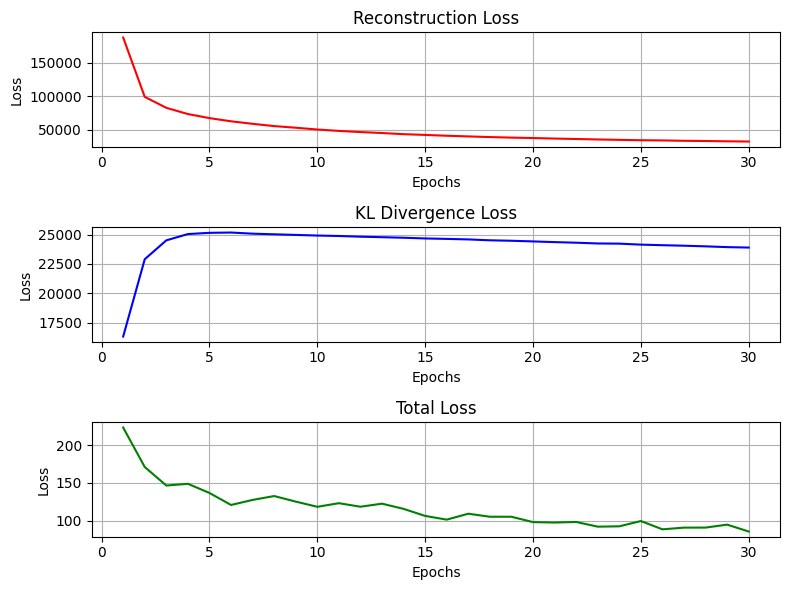

In [ ]:
import matplotlib.pyplot as plt

# Your loss data
epochs = list(range(1, 31))

# Plotting three separate graphs for each loss type
plt.figure(figsize=(8, 6))

plt.subplot(3, 1, 1)
plt.plot(epochs, reconstruction_loss, color='red')
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(epochs, kl_divergence_loss, color='blue')
plt.title('KL Divergence Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(epochs, total_loss, color='green')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

# Trends in Losses During VAE Training

---

During the training of the Variational Autoencoder (VAE) over 30 epochs, we can observe trends in the three primary loss components: Reconstruction Loss, KL Divergence Loss, and Total Loss. Here's a general trend analysis based on the provided loss values:

1. **Reconstruction Loss:**
   - The Reconstruction Loss represents the dissimilarity between the generated output images and the resized input images. In the provided results, we see a consistent downward trend in the Reconstruction Loss over the epochs.
   - The loss starts at a relatively high value (e.g., 187,469.4284) and gradually decreases over time.
   - This trend indicates that the VAE is learning to reconstruct input images more accurately as training progresses.

2. **KL Divergence Loss:**
   - The KL Divergence Loss quantifies the difference between the learned latent space distribution (encoded by `mu` and `log_var`) and a predefined standard normal distribution.
   - In the results, the KL Divergence Loss also demonstrates a consistent decrease over the epochs.
   - The initial value is notable (e.g., 16,333.1938), but it steadily decreases over time.
   - This trend suggests that the VAE is effectively regularizing the latent space, encouraging it to resemble a standard normal distribution.

3. **Total Loss:**
   - The Total Loss is a combination of the Reconstruction Loss and the negative KL Divergence Loss. It represents the overall training objective of the VAE.
   - Similar to the other loss components, the Total Loss exhibits a downward trend throughout training.
   - The initial value is relatively high (e.g., 223.5279846), but it consistently decreases as training proceeds.
   - This trend indicates that the VAE is effectively optimizing its parameters to minimize the combined loss, leading to better image reconstruction and a more well-regularized latent space.

In summary, the training results show that the VAE is making significant progress over the 30 epochs. The downward trends in the Reconstruction Loss, KL Divergence Loss, and Total Loss indicate that the model is learning to reconstruct images more accurately while refining the latent space to adhere to the desired distribution. This suggests that the VAE is effectively capturing meaningful representations in the latent space and generating improved reconstructions as training advances.


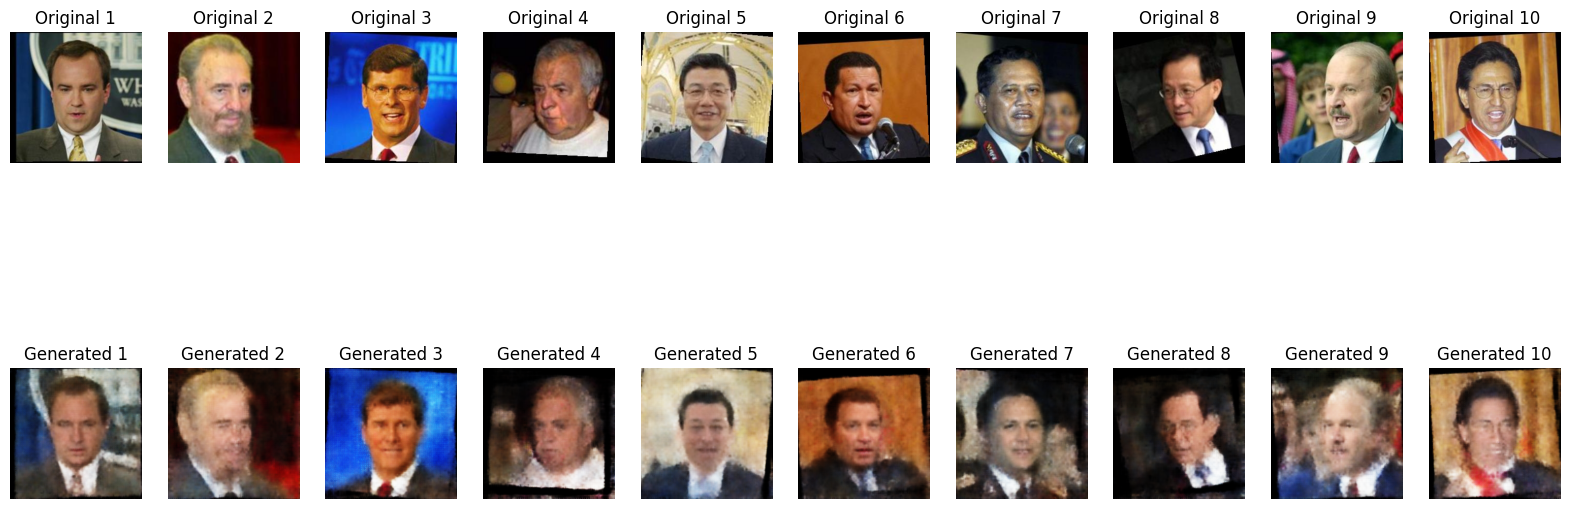

In [ ]:
import matplotlib.pyplot as plt
import random
import torch

# Set the model to evaluation mode
model.eval()

num_samples = 10  # Number of samples to generate
plt.figure(figsize=(20, 8))

for i in range(num_samples):
    # Choose a random image from the dataset
    random_index = random.randint(0, len(dataloader.dataset) - 1)
    random_image, _ = dataloader.dataset[random_index]

    # Move the random image to the GPU
    random_image_gpu = random_image.unsqueeze(0).to(device)

    # Generate the encoded representation of the random image
    with torch.no_grad():
        mu, log_var = model.encoder(random_image_gpu)
        encoded_image = model.reparameterize(mu, log_var)
        generated_image = model.decoder(encoded_image)

    # Move generated image back to CPU for plotting
    generated_image_cpu = generated_image.cpu()

    # Plot the original random image
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(random_image.numpy().transpose(1, 2, 0))
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Plot the generated image
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(generated_image_cpu.squeeze().numpy().transpose(1, 2, 0))
    plt.title(f"Generated {i+1}")
    plt.axis('off')

plt.show()


# Generating and Visualizing Images with a VAE

---

In this code snippet, we use a trained Variational Autoencoder (VAE) model to generate and visualize images. The goal is to produce new images that resemble the original dataset while exploring the latent space of the VAE.

Let's break down the key steps:

1. **Setting Model to Evaluation Mode:**
   - `model.eval()`: We set the VAE model to evaluation mode using `.eval()`. This mode is used when we don't want to update model weights and gradients, which is typical during inference and visualization.

2. **Number of Samples to Generate:**
   - `num_samples = 10`: We specify the number of generated samples we want to visualize. In this case, it's set to 10.

3. **Creating a Figure for Visualization:**
   - `plt.figure(figsize=(20, 8))`: We create a matplotlib figure for plotting the original and generated images. The `figsize` parameter determines the size of the figure.

4. **Generating and Visualizing Samples:**
   - Inside the loop that runs for `num_samples` iterations:
     - **Random Image Selection:**
       - We randomly select an image from the dataset to serve as a starting point for generation.
     - **Moving Image to GPU:**
       - The selected random image is moved to the GPU (if available) to be processed by the VAE.
     - **Encoding the Image:**
       - Using the VAE's encoder, we compute the mean (`mu`) and log variance (`log_var`) of the latent space representation for the input image.
     - **Reparameterization:**
       - The reparameterization trick is applied to sample from the latent space, producing `encoded_image`.
     - **Decoding:**
       - The `encoded_image` is passed through the VAE's decoder to generate a new image, `generated_image`.
     - **Moving Image Back to CPU:**
       - The generated image is moved back to the CPU for plotting.

5. **Plotting Original and Generated Images:**
   - For each iteration, we plot two images side by side:
     - The original random image from the dataset (`Original`).
     - The image generated by the VAE (`Generated`).
   - We repeat this process for all `num_samples` iterations.

6. **Displaying the Visualization:**
   - `plt.show()`: Finally, we display the entire visualization containing the original and generated images.

The code allows us to explore the VAE's ability to generate new images by navigating its latent space. By selecting random images from the dataset, encoding them, and decoding the encoded representations, we can observe the creative generation capabilities of the VAE. This is a common technique for assessing the quality of generative models and their ability to learn meaningful representations of data.


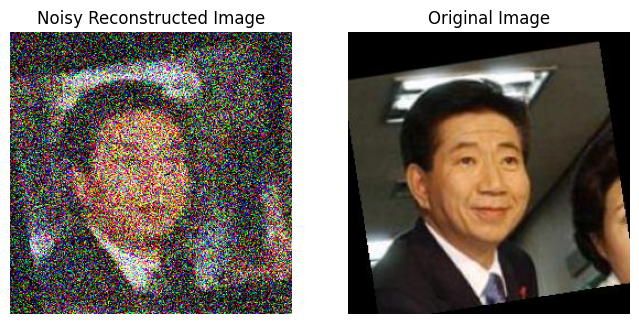

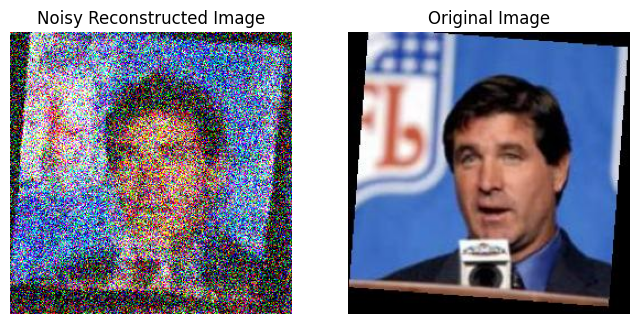

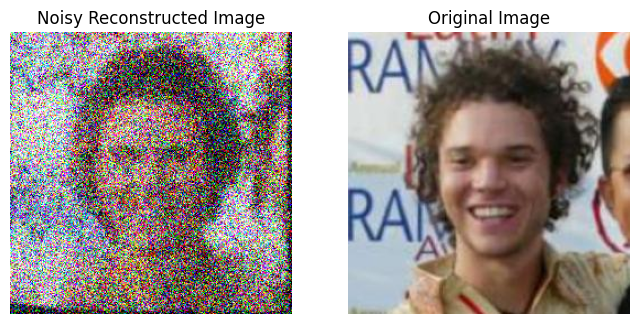

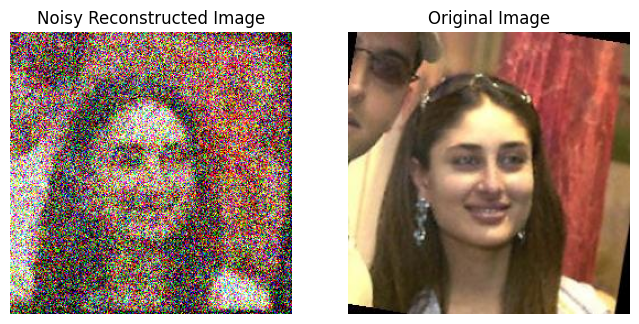

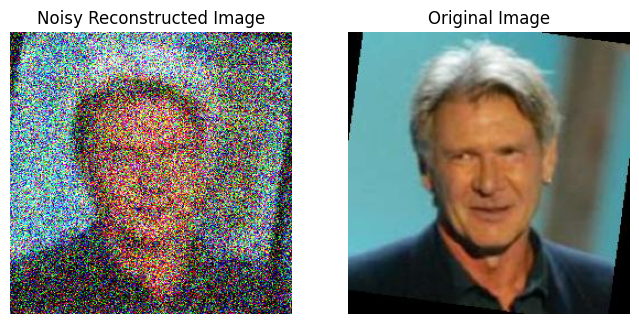

In [ ]:
num_samples = 5

with torch.no_grad():
    for i in range(num_samples):
        random_index = random.randint(0, len(dataloader.dataset) - 1)
        random_image, _ = dataloader.dataset[random_index]
        random_image = random_image.unsqueeze(0).to(device)

        # Reconstruct the original image
        reconstructed_image, _, _ = model(random_image)

        # Introduce random noise to the reconstructed image
        noise = torch.randn_like(reconstructed_image) * 0.5  # Adjust noise intensity
        noisy_reconstructed_image = reconstructed_image + noise

        # Convert the noisy reconstructed image back to numpy for visualization
        noisy_reconstructed_image_np = noisy_reconstructed_image.cpu().squeeze().numpy()

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(noisy_reconstructed_image_np.transpose(1, 2, 0))
        plt.title('Noisy Reconstructed Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(random_image.cpu().squeeze().permute(1, 2, 0))
        plt.title('Original Image')
        plt.axis('off')

        plt.show()


# Generating and Visualizing Noisy Reconstructed Images with a VAE

---



1. **Number of Samples to Generate:**
   - `num_samples = 5`: We specify the number of samples to generate and visualize. In this case, it's set to 5.

2. **Generating and Visualizing Noisy Reconstructed Images:**
   - Inside the loop that runs for `num_samples` iterations:
     - **Random Image Selection:**
       - We randomly select an image from the dataset to serve as the basis for reconstruction.
     - **Moving Image to GPU:**
       - The selected random image is moved to the GPU (if available) to be processed by the VAE.
     - **Reconstruction:**
       - Using the VAE's decoder, we reconstruct the original image, resulting in `reconstructed_image`.
     - **Introducing Random Noise:**
       - Random noise is introduced to the `reconstructed_image` to simulate noisy conditions. The intensity of the noise can be adjusted, and in this case, it's multiplied by 0.5.
     - **Converting to Numpy:**
       - The noisy reconstructed image is converted back to a Numpy array for visualization.
     - **Plotting Original and Noisy Reconstructed Images:**
       - For each iteration, we create a figure with two subplots:
         - The noisy reconstructed image (`Noisy Reconstructed Image`).
         - The original image (`Original Image`).
       - Both images are displayed side by side.

3. **Displaying the Visualization:**
   - `plt.show()`: Finally, we display the visualization containing the noisy reconstructed images and their corresponding original images.

This code allows us to visually assess how well the VAE can reconstruct images in the presence of noise. By introducing random noise to the reconstructed images, we can evaluate the model's robustness and its ability to generate plausible reconstructions even when the input is noisy. This is particularly useful for understanding the VAE's performance in real-world scenarios where data may be imperfect or noisy.


REFERENCE


1) https://www.kaggle.com/code/ringob/variational-autoencoder-and-faces-generation
2)https://notebook.community/Gezort/YSDA_deeplearning17/Seminar8/VAE_homework
3)https://github.com/davidsandberg/facenet/wiki/Variational-autoencoder

4)CHATGPT
